### Pymc and Pooling

Problem Setup

In our example, we need to sample posterior and find its maximize value using PyMC. The data we have in this problem is the score difference between two teams. We agree to use the following formula to calculate the score difference

$$diff = GuestScore(PTS) - HostScore(PTS.1)$$

The score difference(diff) follows a Gaussian distribution $N(\mu,\sigma)$. The $\mu$ is determined by:

$$\mu = (O_i - D_j ) - (O_j - D_i)$$ where O is the offensive index and D is the defensive index for one team. Offensive and 

Defensive indexes shall be calculated by the following formulas:

$$ O_{i} = \beta_{i,0}^O + \beta_{i,1}^O x_{i,1} + \beta_{i,2}^O x_{i,2} +\ldots + \beta_{i,J}^O x_{i,J}$$
$$D_{i} = \beta_{i,0}^D + \beta_{i,1}^D x_{i,1} + \beta_{i,2}^D x_{i,2} + \ldots + \beta_{i,J}^D x_{i,J}$$

You can see that $x_i$ is the offensive/defensive rating for each player, we need to figure out $\beta$ in this problem.

Our observed values here are score difference. We assume it follows a normal distribution, which means we could estimate its mean value, then find the $\beta$. 


**Therefore, our score difference Gaussian is actually a MIXTURE MODEL consisting of many gaussian of different team pairs, so can be written as:**

$$\prod_{n=1}^N N(\mu_{nk},\sigma)^{z_nk}$$ Where $z_nk$ is an indicator showing which team pair the nth data belong to.

**Our goal is to find each $\beta$ value**

Thus, we assume there are $K$ players, and each team has $N$ players, so we initialize:

K ($N*1$) vectors  $\beta$ and 


K ($N*1$) vectors $\gamma$

So, 

$$Offensive = \beta * X$$ where X is 1*N offensive rating

$$Defensive = \gamma * Y$$ where Y is 1*N defensive rating 







In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
import pickle

/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Import data
game16_df = pd.read_csv('clean-data/game_outcomes_15-16.csv')
player_info = pd.read_csv('clean-data/player_info.csv')

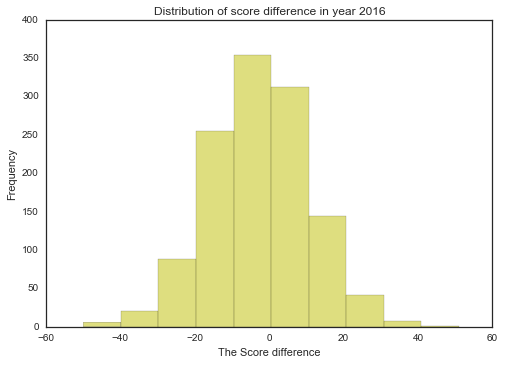

In [4]:
score_diff = game16_df['diff'].values
#plot a histogram
plt.hist(score_diff,color='y',alpha = 0.5)
plt.title("Distribution of score difference in year 2016")
plt.xlabel('The Score difference')
plt.ylabel('Frequency')

In [5]:
# Here we have sigma for the entire data set and assume this sigma as my likehood variance as well
print "The variance of the entire data set is:",np.var(score_diff)

The variance of the entire data set is: 177.785299755


#### As you can see, the score difference follows a normal distribution

### Peek into our prior
Here I plot the Offensive rating and defensive rating to have a basic idea what our prior would be like

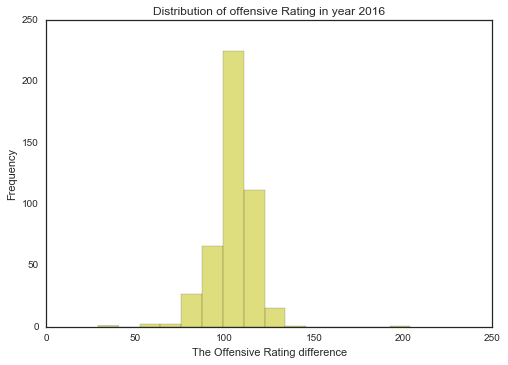

In [6]:
#plot a histogram
ortg_values = player_info['ORtg'].values
plt.hist(ortg_values,color='y',bins=15,alpha =0.5)
plt.title("Distribution of offensive Rating in year 2016")
plt.xlabel('The Offensive Rating difference')
plt.ylabel('Frequency')


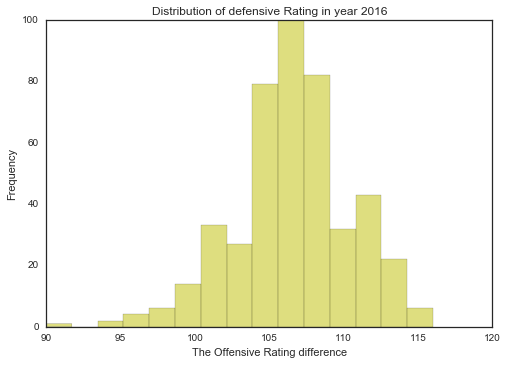

In [7]:
#plot a histogram
drtg_values = player_info['DRtg'].values
plt.hist(drtg_values,color='y',bins=15,alpha =0.5)
plt.title("Distribution of defensive Rating in year 2016")
plt.xlabel('The Offensive Rating difference')
plt.ylabel('Frequency')

From the two plots above, we see that our two ratings could be treated as two normal distributions with two different shapes. Although for defensive ratings, it looks like a mixture Gaussian model, for the simplistic of this problem, we decided to treat them as normal distributions. 


Before we get to the further part, we need to figure out players in each team. We use binary indicators in this problem, which has the length of "player_num" vector will be generated, and if this player is playing, the number will be 1, 0 otherwise. 

In [8]:
# Initialize beta and gamma for each player
N = len(player_info)
beta = np.empty(N, dtype=object)
gamma = np.empty(N, dtype=object)
for i in range(N):
    beta[i] = pm.Normal('beta_%i' % i, mu=0, tau=1)
    gamma[i] = pm.Normal('gamma_%i' % i, mu=0, tau=1)
beta = pm.Container(beta)
gamma = pm.Container(gamma)

/Users/xdai/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


In [14]:
# import the pickle files for guest/host teams line_up
with open('clean-data/guest_team_line_up.pkl', 'rb') as handle:
    guest_team_line_up = pickle.load(handle)
with open('clean-data/host_team_line_up.pkl','rb') as handle:
    host_team_line_up = pickle.load(handle)

In [9]:
# Pymc Part
# 1*n beta vector, n is the number of players inside one team
# n*1 x vector, x could be either defensive or offensive
# Each player's contribution could be understood as positive and negative
# Each player's distribution could be treated as independently, with mu = 0
# To figure out the mean value for normal distribution
# (beta*x - gamma*x2) - (beta*x2 - gamma*x1)

In [17]:
@pm.observed
def likelihood(offensive_x = ortg_values , defensive_y = drtg_values,beta = beta,gamma = gamma,
               guest_team_line_up = guest_team_line_up,host_team_line_up = host_team_line_up, value = score_diff):
    likelihood = 0
    for i in range(0, len(value)):
        # select team members and dot product their beta and ratings
        # mean shall follow: (O_i - D_j ) - (O_j - D_i)
        guest_indicator = guest_team_line_up[i]
        host_indicator = host_team_line_up[i]
        guest_diff = offensive_x[guest_indicator].dot(beta[guest_indicator]) - defensive_y[host_indicator].dot(gamma[host_indicator])
        host_diff = offensive_x[host_indicator].dot(beta[host_indicator]) - defensive_y[guest_indicator].dot(gamma[guest_indicator])
        mean = guest_diff - host_diff
        likelihood += pm.normal_like(value[i], mean, 1)
    return likelihood

In [ ]:
parameterlist = [likelihood, beta, gamma]
response_model=pm.Model(parameterlist)
mcmc = pm.MCMC(response_model)
# mcmc.sample(iter=100, burn = 5000, thin = 2)

In [18]:
print "yes"

yes


In [36]:
mcmc.sample(iter=50000, burn = 500, thin = 2)

 [-----------------100%-----------------] 50000 of 50000 complete in 1131.1 sec

In [58]:
mcmc.summary()


beta_70:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.006           1.012            0.006              [-1.89  2.08]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-1.986           -0.694          -0.003         0.68          1.994
	

gamma_184:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.003           1.002            0.005            [-1.944  1.985]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-1.958           -0.683          -0.003         0.674         1.976
	

beta_184:
 
	Mean             SD               MC Error        95% HPD interval
	------------

In [52]:
test_res = pm.geweke(mcmc.trace('beta_21')[:], first=0.1, last=0.5, intervals=20)

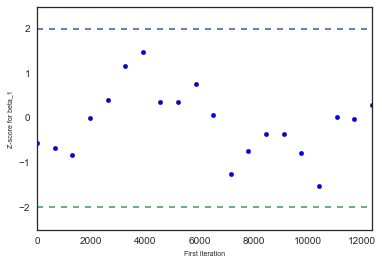

In [57]:
pm.Matplot.geweke_plot(test_res,'beta_1')

In [59]:
mcmc.write_csv("pymcResult.csv")

In [60]:
# Read csv and analyze the data
pymc_result = pd.read_csv('pymcResult.csv')

In [77]:
test_res = pymc_result[['Parameter',' Mean']]

In [107]:
beta_result = test_res.sort_values(['Parameter'])[:475]

In [108]:
gamma_result = test_res.sort_values(['Parameter'])[475:]

In [110]:
beta_result = beta_result.reset_index(drop=True)

In [116]:
# beta_result.sort_values([' Mean'],ascending=False)

In [120]:
beta_result.sort_values([' Mean'])

,Parameter,Mean
386,beta_446,-0.019154
418,beta_48,-0.016880
291,beta_360,-0.016800
315,beta_382,-0.016717
359,beta_421,-0.015757
280,beta_350,-0.015606
155,beta_238,-0.015090
369,beta_430,-0.014738
203,beta_281,-0.014572
43,beta_137,-0.014499


In [137]:
index = [int(beta_str.split("_")[1]) for beta_str in beta_result["Parameter"]]
beta_result['Index'] = index
beta_result = beta_result.set_index(['Index'])

In [143]:
beta_ascending_index = beta_result.sort_values([' Mean'],ascending=False).index

In [155]:
player_names = player_info.sort_values(['Player'],ascending=True)['Player'].values

In [162]:
player_names[beta_ascending_index[2:10]]

array(['Monta Ellis', 'Ed Davis', 'Cliff Alexander', 'Gary Neal',
       'P.J. Tucker', 'Tiago Splitter', 'Pau Gasol', 'Derrick Favors'], dtype=object)